<a href="https://colab.research.google.com/github/minoooo119/2023webprogramming_final_project/blob/main/AIP_week5_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 5: GNN
**Course Title**: AI project (SWE3032-41)

**Date**: 2024.04.01

**Due date**: 2024.04.07 23:59

**Contact**: jhbae0219@gmail.com

\\

Welcome to our 5th lab class. The following notebook is meant to give an experience of understanding and implementing the GNN model.

\\
**Why use GNN?**

 Most data can be expressed into the graph data structure. GNN handles graph data as an input and perform various downstream tasks.

**What is various downstream tasks?**

Three main downstream tasks are designed, which is graph classification, node classification, and link prediction respectively.

<img src="https://theaisummer.com/static/a1edb6dc313bee303c14425b93da02b1/17a7a/graph-vs-node-classification.png" height="300px" width="700px">
<img src="https://i.imgur.com/bAKxgkB.png" height="300px" width="700px">





\\



Today, we are going to implement node classification task

In [ ]:
from __future__ import division
from __future__ import print_function

import time

import math
import torch

import numpy as np
import scipy.sparse as sp
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

**Mount the google drive**

Below code is to mount the google drive. If so, we can upload the the big-data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Functions for implementation**

- *encode_onehot*:  
change the label information into one-hot fixed size vector

- *sparse_mx_to_torch_sparse_tensor*:  
most of the elements on the adjacency matrix is 0 (data is usually sparse).  
Therefore, we use sparse tensor of sparse matrix on scipy.  
This function transforms the scipy sparse matrix into torch sparse matrix.

- *normalize*:  
We need to normalize the adjacency matrix to avoid the vanishing/exploding gradients and also the vecotrs.

In [ ]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot
    #label을 원핫으로 바꿔주는것

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)
    #sparse tensor , 0이라는 값이 많게 되면 불필요 그래서 모든 경우 다 따지기 어려우니까 실제 관계가 있는 정보만 저장
    #sparse tentor로 구현이 가능하다

def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

    #신경쓸필요는 없다

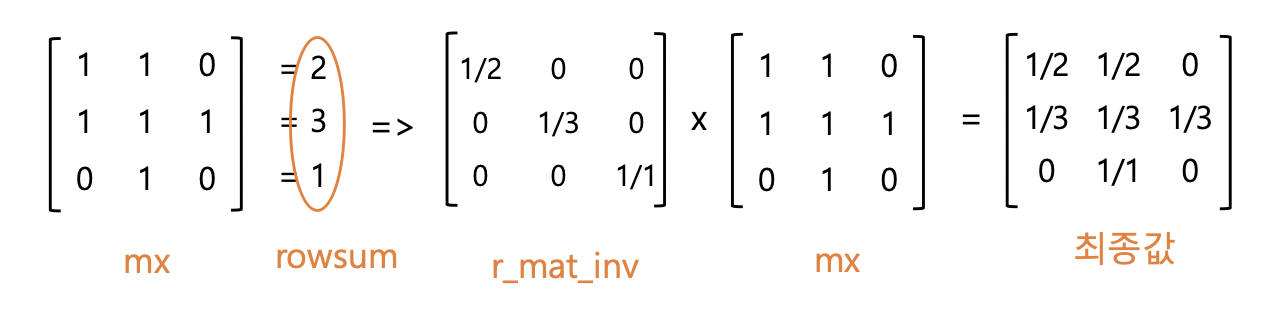

##Graph data preprocessing
We will learn famous citation data, Cora. The Cora dataset consists of 2708 scientific papers classified into one of seven classes.

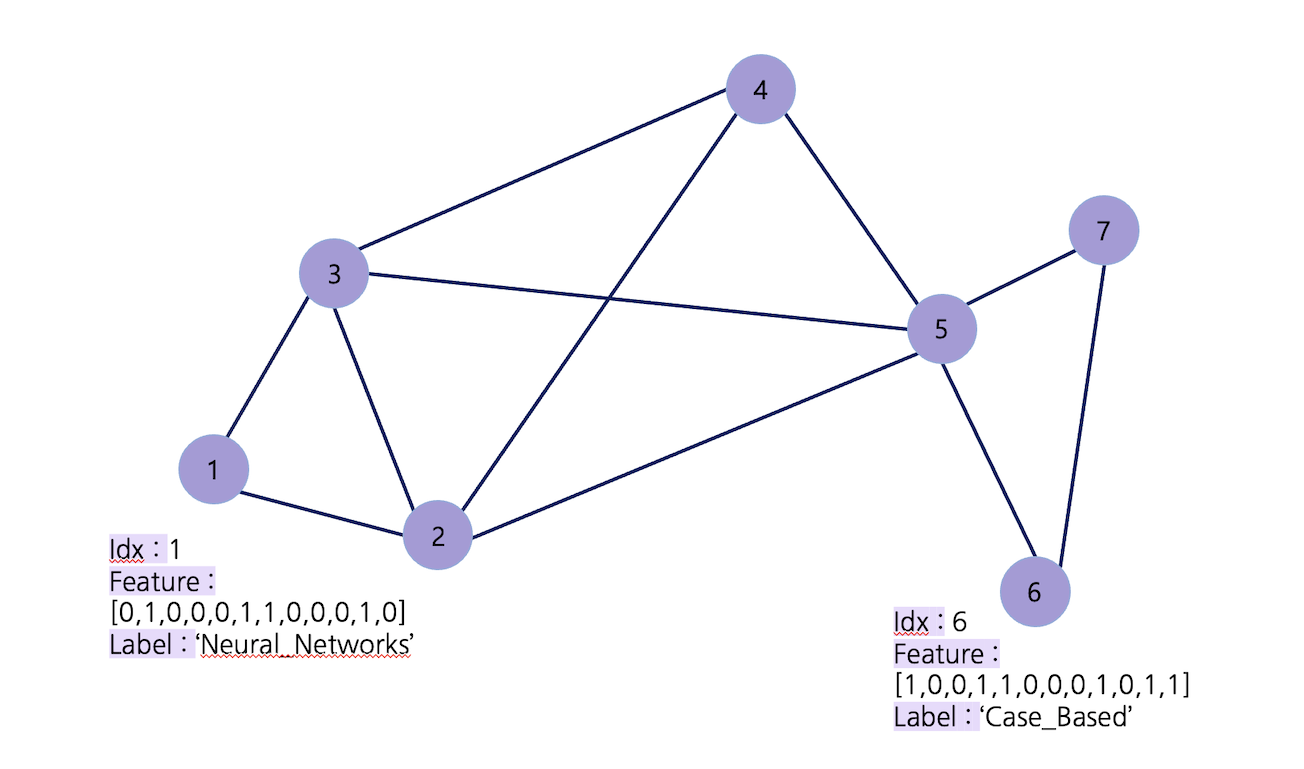

**Cora dataset**

\# of nodes: 2708.  
\# of features: 1433 (0 or 1, absence/presence of the corresponding word).  
\# of labels: 7

In [ ]:
#load data
path = "/content/drive/MyDrive/인지프/week5/"
dataset ="cora"
import os
file_path = f"{path}{dataset}.content"
if os.path.exists(file_path):
    print("파일이 존재합니다.")


#node data processing
print(path+dataset+".content")
try:
    node_data = np.genfromtxt(file_path, dtype=np.dtype(str))
    print(f"The number of nodes : {len(node_data)}")
    print(node_data)
except Exception as e:
    print("파일 읽기 실패:", e)


파일이 존재합니다.
/content/drive/MyDrive/인지프/week5/cora.content
The number of nodes : 2708
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]


In [ ]:
idx = np.array(node_data[:,0], dtype=np.int32)
features = sp.csr_matrix(node_data[:,1:-1], dtype=np.float32)
labels = encode_onehot(node_data[:,-1])

idx_map = {j: i for i, j in enumerate(idx)}

print(f'idx : {node_data[12,0]}')
print(f'a feature size : {len(node_data[12,1:-1])}, {node_data[12,1:-1]}')
print(f'a original label : {node_data[12,-1]}')
print(f"encoding label : {labels[12]}")


idx : 109323
a feature size : 1433, ['0' '0' '1' ... '0' '0' '0']
a original label : Probabilistic_Methods
encoding label : [0 0 1 0 0 0 0]


In [ ]:
#edge data processing
edge_data = np.genfromtxt(f'{path}{dataset}.cites', dtype=np.int32)
edges = np.array(list(map(idx_map.get, edge_data.flatten())), dtype=np.int32)
edges = edges.reshape(edge_data.shape)

print(f'{len(edge_data)} \n raw data \n {edge_data[:10,]}')
print(f'\n start node -> end node \n {edges}')

5429 
 raw data 
 [[     35    1033]
 [     35  103482]
 [     35  103515]
 [     35 1050679]
 [     35 1103960]
 [     35 1103985]
 [     35 1109199]
 [     35 1112911]
 [     35 1113438]
 [     35 1113831]]

 start node -> end node 
 [[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


**Graph Neural Network**

The main assumption behind GNN is homophily, which is that the similar features are found on their neighbors. The adjacency matrix encodes these neighborhood relationships.
A Graph Neural Network (GNN) typically operates in two phases: aggregation and combination. In the aggregation phase, a node collects information from its neighbors, reflecting the principle of homophily. During the combination step, the aggregated data and the node's existing features are integrated, often through a neural network layer, to update the node's representation.

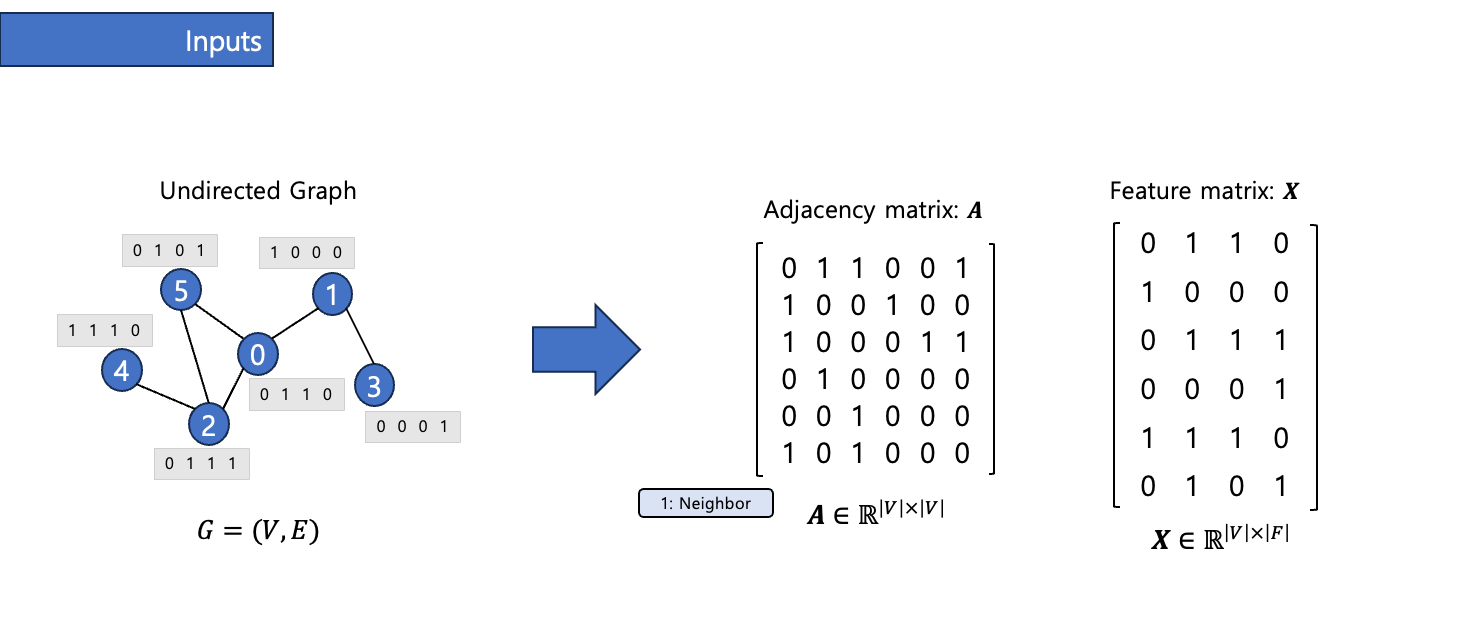

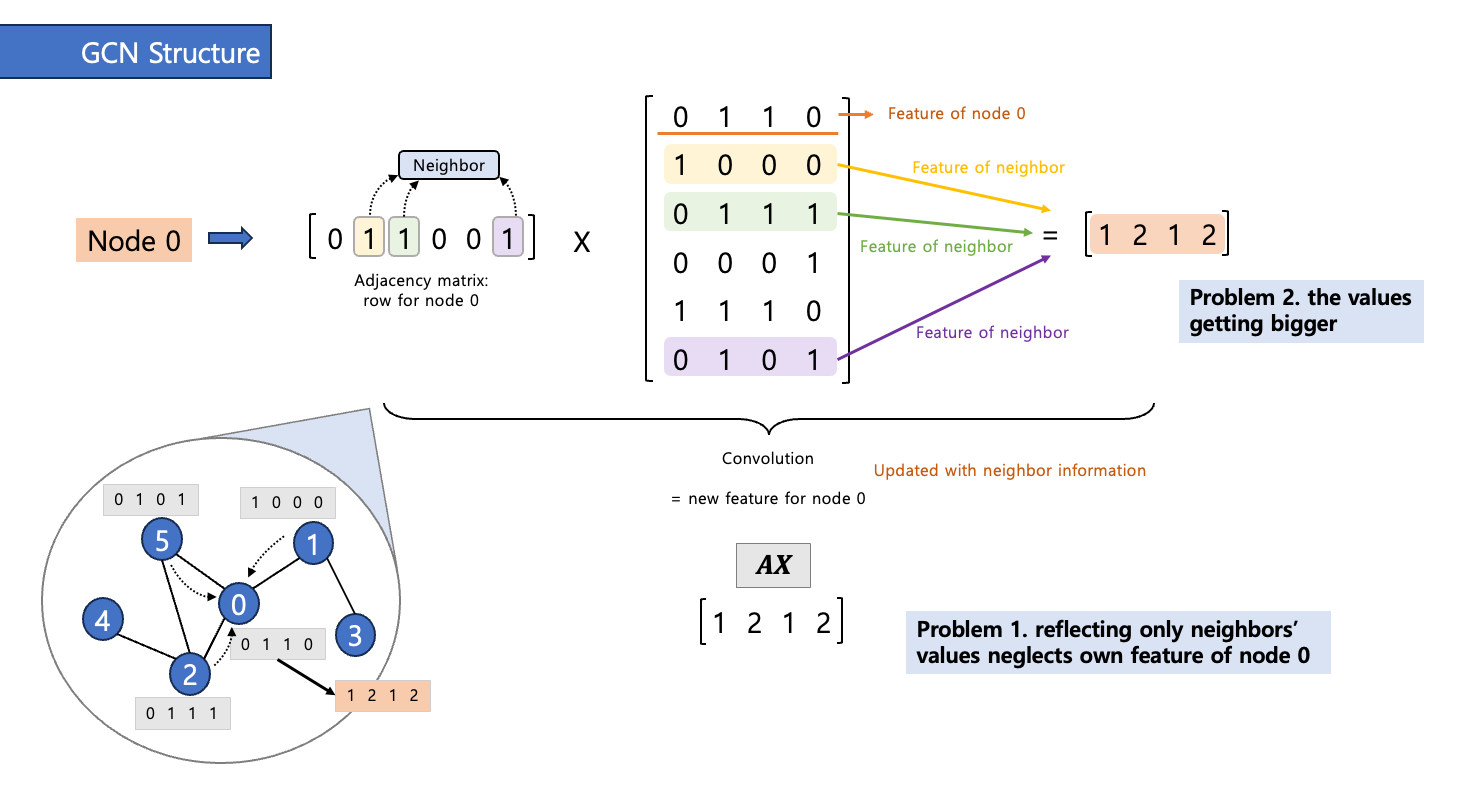

이웃 정보에 대해서만 취합해서 feature를 만들어줌

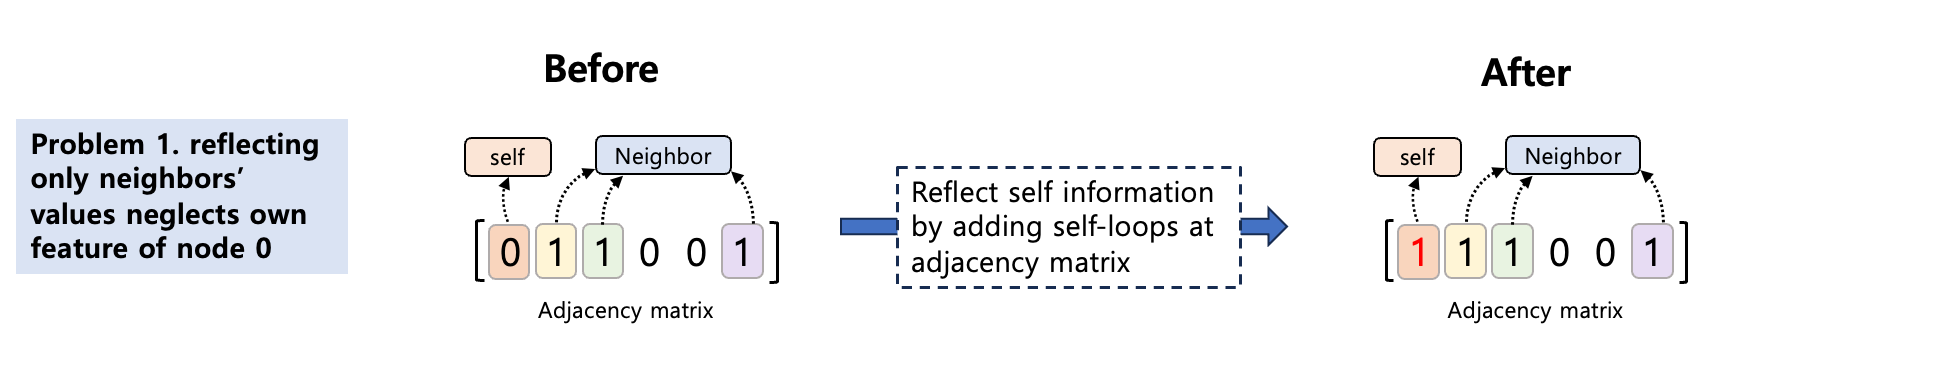

본인 정보가 없기때문에 추가함

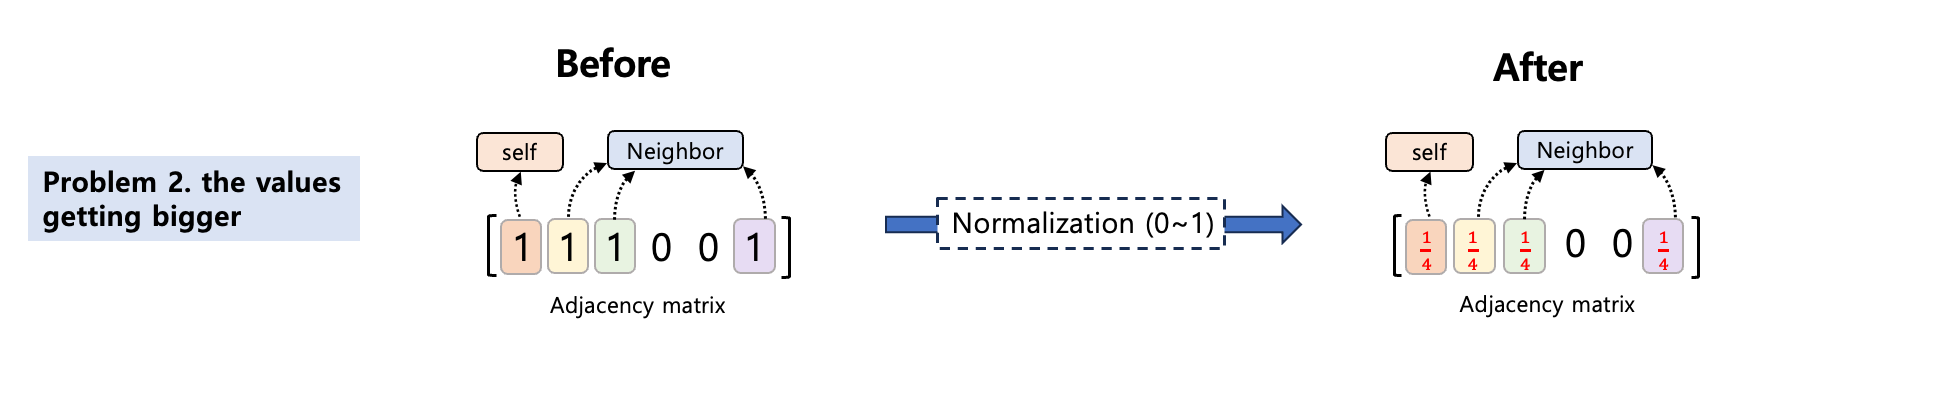

그리고 normalization도 진행

##Problem 1 (4 points)
#### 1. Practice handling an adjacency matrix for graph data (3 points)
- number of nodes: 6
- number of features: 10
- Create an adjacency matrix. (1 point)
- Generate a feature matrix. (1 point)
- Multiply two matrices. (1 point)

#### 2. Graph Neural Network (GNN) Characteristics (1 point)
- What are the advantages and disadvantages of reflecting information from neighbors?  
Please feel free to provide your own answers.


### Be sure to check your final submission for any truncated or oddly printed answers, as this can be a deduction factor.

In [ ]:
# Write down your answers here.

# 1-1.
import numpy as np

# Number of nodes and features
num_nodes = 6
num_features = 10

# Create adjacency matrix (assuming undirected graph for simplicity)
adjacency_matrix = np.random.randint(0, 2, size=(num_nodes, num_nodes))
adjacency_matrix = np.tril(adjacency_matrix) + np.tril(adjacency_matrix, -1).T  # Ensure symmetry for undirected graph

# Print adjacency matrix
print("Adjacency Matrix:")
print(adjacency_matrix)

# Generate feature matrix
feature_matrix = np.random.rand(num_nodes, num_features)

# Print feature matrix
print("\nFeature Matrix:")
print(feature_matrix)

# Multiply adjacency matrix and feature matrix
result_matrix = np.matmul(adjacency_matrix, feature_matrix)

# Print result matrix
print("\nResult Matrix (Adjacency Matrix * Feature Matrix):")
print(result_matrix)

# 1-2.

# 장점: 이웃으로부터 정보를 반영하면 지역적 맥락을 활용하여 노드의 풍부한 표현을 얻을 수 있습니다.

# 단점: 너무 많은 이웃 정보를 반영하면 정보 전파 제한과 계산 복잡성 문제가 발생할 수 있습니다.


Adjacency Matrix:
[[1 1 0 1 1 1]
 [1 1 1 1 1 1]
 [0 1 1 1 0 1]
 [1 1 1 1 0 0]
 [1 1 0 0 1 1]
 [1 1 1 0 1 0]]

Feature Matrix:
[[0.13366353 0.78001342 0.06385464 0.3220153  0.93898743 0.84251892
  0.83802254 0.01349797 0.81941235 0.35172821]
 [0.80701463 0.29866251 0.32710631 0.78967089 0.28697218 0.08577658
  0.81575492 0.27123721 0.90284131 0.42248948]
 [0.38541254 0.23454811 0.64848123 0.4624851  0.17328119 0.17040428
  0.81094123 0.48695171 0.2935576  0.98174743]
 [0.78111799 0.07737582 0.62280924 0.51735125 0.6104048  0.14269274
  0.57026737 0.04696642 0.05760538 0.27454751]
 [0.49075409 0.2129588  0.26947698 0.77376939 0.9631951  0.13811913
  0.20049085 0.45613609 0.08328011 0.25603686]
 [0.57213056 0.98754214 0.50213883 0.83975626 0.76065654 0.99801768
  0.75930223 0.51082875 0.2166295  0.61072146]]

Result Matrix (Adjacency Matrix * Feature Matrix):
[[2.7846808  2.35655268 1.78538601 3.24256309 3.56021606 2.20712505
  3.1838379  1.29866645 2.07976865 1.91552352]
 [3.17009334 2.5

**Create and Normalize the adjacency matrix**

If the target node has many edges, aggregating information on every neighbors is enormous.  
However, if the node has low degree, the information is small.  
To overcome the information overload, the normalization allows every node's aggregate information as equal.

In [ ]:
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:,0], edges[:,1])),
                    shape = (labels.shape[0], labels.shape[0]),
                    dtype = np.float32)
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

#normalize
features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0]))

**Split and tensorize data for semi-supervised learning**

For semi-supervised learning, a small subset of the data is labeled. The objective is to leverage this labeled data to infer the labels of the remaining unlabeled data. The training process utilizes the labeled instances to guide the model, enabling it to make predictions for the unlabeled instances.


In [ ]:
#data split - semi supervised learning
idx_train = range(150) #적다
idx_val = range(150, 500)
idx_test = range(500, 1500)

#tensorize
features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

<ipython-input-3-6f93dd05cbe3>:16: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  return torch.sparse.FloatTensor(indices, values, shape)


**Graph Convolutional Network Model Implementation**



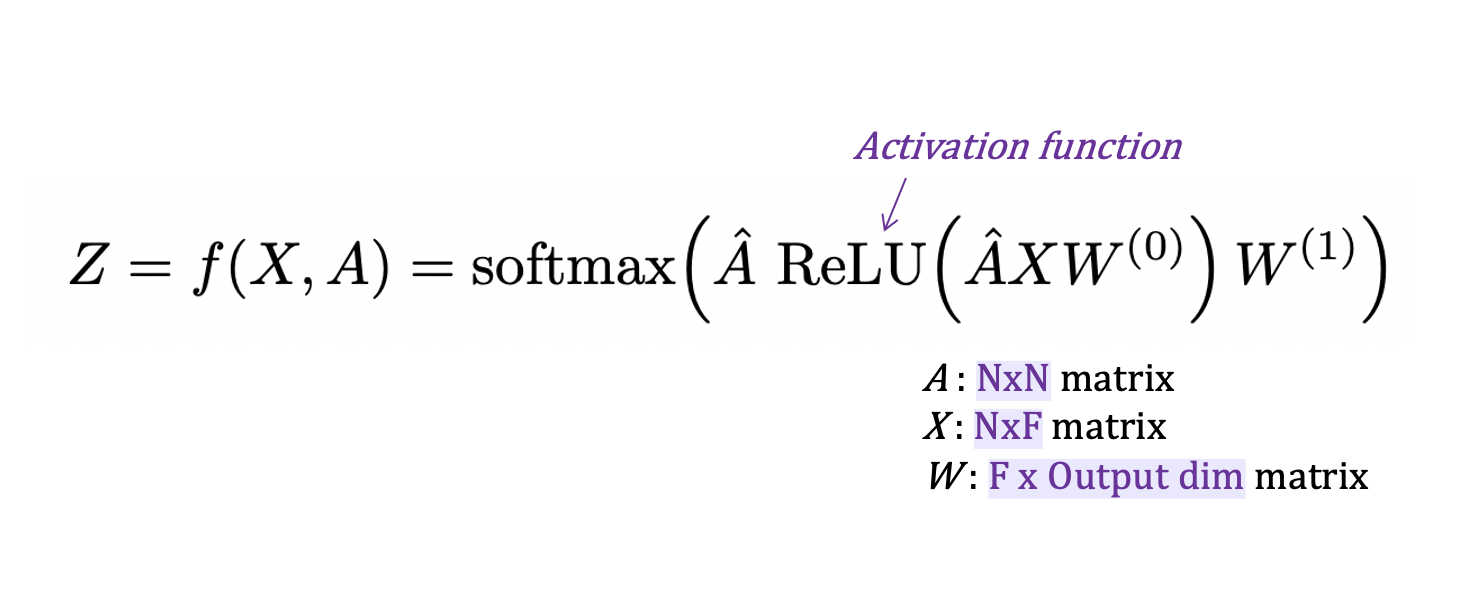

GCN 층을 쌓으면서 더 떨어진 친구 정보도 포함해서 학습을 할 수 있다,

In [ ]:
# GCN layer
# GCN 하나 Layer
class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [ ]:
#model
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [ ]:
#Main
import easydict

args = easydict.EasyDict({"no-cuda":False, "fastmode":False, "seed":42, \
                          "epochs":200, "lr":0.01, "weight_decay":5e-4, \
                          "hidden":16, "dropout":0.5, "cuda":False})

np.random.seed(args.seed)
torch.manual_seed(args.seed)

model = GCN(nfeat= features.shape[1] ,
            nhid= args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)

optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    torch.cuda.manual_seed(args.seed)
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [ ]:
def train(epoch):
    t = time.time()

    model.train()
    optimizer.zero_grad()
    #forward
    output = model(features , adj)

    #calculate loss
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])

    loss_train.backward()
    optimizer.step()

    #calculate validation loss
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print(f'[Epoch {epoch+1:04d}] Train_loss: {loss_train.item():.4f}, Train_accuracy: {acc_train.item():.4f},',
          f'Val_loss: {loss_val.item():.4f}, Val_accuracy: {acc_val.item():.4f}, \n #Time: {time.time() - t:.4f}')

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [ ]:
#train model
t_total = time.time()
for e in range(args.epochs):
    train(e)
print(f"Total time elapsed: {time.time() - t_total:.4f}")

[Epoch 0001] Train_loss: 0.2558, Train_accuracy: 0.9733, Val_loss: 0.6814, Val_accuracy: 0.8057, 
 #Time: 0.0165
[Epoch 0002] Train_loss: 0.2228, Train_accuracy: 0.9733, Val_loss: 0.6680, Val_accuracy: 0.8000, 
 #Time: 0.0170
[Epoch 0003] Train_loss: 0.2717, Train_accuracy: 0.9600, Val_loss: 0.7240, Val_accuracy: 0.7714, 
 #Time: 0.0138
[Epoch 0004] Train_loss: 0.2739, Train_accuracy: 0.9733, Val_loss: 0.6932, Val_accuracy: 0.7686, 
 #Time: 0.0091
[Epoch 0005] Train_loss: 0.2816, Train_accuracy: 0.9733, Val_loss: 0.6891, Val_accuracy: 0.7857, 
 #Time: 0.0092
[Epoch 0006] Train_loss: 0.2713, Train_accuracy: 0.9667, Val_loss: 0.6921, Val_accuracy: 0.8000, 
 #Time: 0.0088
[Epoch 0007] Train_loss: 0.2407, Train_accuracy: 0.9733, Val_loss: 0.6802, Val_accuracy: 0.7886, 
 #Time: 0.0086
[Epoch 0008] Train_loss: 0.2626, Train_accuracy: 0.9733, Val_loss: 0.7105, Val_accuracy: 0.7714, 
 #Time: 0.0081
[Epoch 0009] Train_loss: 0.2435, Train_accuracy: 0.9733, Val_loss: 0.7187, Val_accuracy: 0.7971,

In [ ]:
def test():
    model.eval()
    output = model(features, adj)

    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          f"loss= {loss_test.item():.4f}",
          f"accuracy= {acc_test.item():.4f}")

In [ ]:
# Testing
test()

Test set results: loss= 0.5869 accuracy= 0.8400


##Problem 2 (4 points)


#### 1. Modify the code to train a GCN Model (2 point)

- Fill in the provided code parts marked with '###'
 to successfully train and test the GCN model.


#### 2. Explain learnable parameters of the GCN Model (2 points)
- Where are parts of the GCN model that learn and adapt  during training? \\
Find the code and explain the size of the learnable parameters. \\
(Hint: The provided GCN model consists of two layers.)

### Be sure to check your final submission for any truncated or oddly printed answers, as this can be a deduction factor.

In [ ]:
# write down your answer here.

# 2-2.
# 매개변수는 주로 GCN 레이어의 weight와 bias 입니다

# self.gc1 = GraphConvolution(nfeat, nhid)
# 두개의 layer로 구성되어있는데, 처음 layer에서는 학습가능한 parameter의 크기는
# (입력 특징 크기 * 은닉층 크기) + 은닉층 크기 입니다.

# self.gc2 = GraphConvolution(nhid, nclass)
# 두번째 layer에서 학습가능한 parameter 크기는
# (은닉층 크기 * 클래스 수) + 클래스 수 입니다.